In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth

auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130811 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from tqdm import trange
import matplotlib.ticker as ticker
%matplotlib inline

import torch
import gc
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [0]:
start_token = "_"
eos = '#'
MAX_LENGTH = 40

In [0]:
data_pairs = pd.read_csv("drive/diploma/base_pairs.csv", index_col=0)
data_pairs.loc[:,"word_form"] = data_pairs.word_form.apply(lambda x: x + eos)
data_pairs.loc[:,"word_norm"] = data_pairs.word_norm.apply(lambda x: start_token + x + eos)
data_pairs.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,lex_id,word_norm,word_form,morph_features_form,morph_features_norm
0,1,_ёж#,ежа#,"NOUN,anim,masc sing,gent","NOUN,anim,masc sing,nomn"
1,1,_ёж#,ежу#,"NOUN,anim,masc sing,datv","NOUN,anim,masc sing,nomn"
2,1,_ёж#,ежа#,"NOUN,anim,masc sing,accs","NOUN,anim,masc sing,nomn"
3,1,_ёж#,ежом#,"NOUN,anim,masc sing,ablt","NOUN,anim,masc sing,nomn"
4,1,_ёж#,еже#,"NOUN,anim,masc sing,loct","NOUN,anim,masc sing,nomn"


In [0]:
s = "".join(data_pairs.word_norm)
tokens = np.sort(np.array(list(set(s))))
    
tok2id = dict(zip(tokens, np.arange(tokens.shape[0])))
id2tok = dict(zip(np.arange(tokens.shape[0]), tokens))

print ('There are {} tokens',len(tokens))

print('Vocabular: ' + "".join(tokens))

# np.save('drive/diploma/vocabulary/tok2id.npy', tok2id)
# np.save('drive/diploma/vocabulary/id2tok.npy', id2tok)

There are {} tokens 48
Vocabular: #'-0123456789_абвгдежзийклмнопрстуфхцчшщъыьэюяё’


In [0]:
import re

set_morph = set()
for i in range(data_pairs.shape[0]):
  loc = re.split(",| ", data_pairs.morph_features_form.values[i])
  for elem in loc:
    set_morph.add(elem)

tokens_f = np.sort(np.array(list(set_morph)))
tok2id_f = dict(zip(tokens_f, np.arange(tokens_f.shape[0])))
# np.save('drive/diploma/vocabulary/tok2id_f.npy', tok2id_f) 

print ('There are {} tokens',len(tokens_f))
print('Vocabular: ' + "".join(tokens_f))

There are {} tokens 100
Vocabular: 1per2per3perADJFADJSADVBAbbrAdjxAf-pAnphAnumAproArchCOMPCONJCmp2CollCounDistDmnsErroFimpFixdGNdrGRNDGeoxHypoINFNINTJImpeImpxInfrInitInmxLitrMs-fNOUNNPRONUMRNameOrgnPRCLPREDPREPPRTFPRTSPatrPltmPossPrdxPrntQualQuesSgtmSlngSubxSuprSurnV-beV-biV-ejV-enV-eyV-ieV-oyV-shVERBVpreabltaccsactvanimdatvexclfemnfutrgen1gen2gentimpfimprinaninclindcintrloc1loc2loctmascms-fneutnomnpastperfplurprespssvsingtranvoct


In [0]:
a = data_pairs.morph_features_form.apply(lambda x: re.split(",| ", x)).values

max_len = 0
for elem in a:
    max_len = max(max_len, len(elem))
print(max_len)

11


In [0]:
SOS_token = tok2id[start_token]
EOS_token = tok2id[eos]

In [0]:
def to_matrix(words, max_len=None, pad=tok2id[eos], dtype=np.int64):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(tok2id.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    return words_ix

In [0]:
print('\n'.join(data_pairs.word_form[:10]))
print(to_matrix(data_pairs.word_form[:10]))

ежа#
ежу#
ежа#
ежом#
еже#
ежи#
ежей#
ежам#
ежей#
ежами#
[[19 20 14  0  0  0]
 [19 20 33  0  0  0]
 [19 20 14  0  0  0]
 [19 20 28 26  0  0]
 [19 20 19  0  0  0]
 [19 20 22  0  0  0]
 [19 20 19 23  0  0]
 [19 20 14 26  0  0]
 [19 20 19 23  0  0]
 [19 20 14 26 22  0]]


In [0]:
tok2id_f[eos] = 100

def to_matrix_f(words, max_len=None, pad=tok2id_f[eos], dtype=np.int64):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        word_ix = list(map(tok2id_f.get, words[i]))
        words_ix[i, :len(word_ix)] = word_ix

    return words_ix

In [0]:
# Creating training and validation sets using an 80-20 split

indices = data_pairs.lex_id.unique()
np.random.seed(42)
np.random.shuffle(indices)
data_pairs.set_index("lex_id", inplace=True)
train = data_pairs.loc[indices[:int(0.8 * indices.shape[0])]]
input_train = train.drop("word_form", axis=1)
target_train = train.word_form.values

test = data_pairs.loc[indices[int(0.8 * indices.shape[0]):]]
input_test = test.drop("word_form", axis=1)
target_test = test.word_form.values

In [0]:
class pairs_Dataset(Dataset):
    def __init__(self, data, data_form):
        self.data = data
        self.target = data_form
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.data.word_norm.values[index], self.data.morph_features_form.values[index], self.target[index], self.data.morph_features_norm.values[index]

In [0]:
BATCH_SIZE = 512

train_data = pairs_Dataset(input_train, target_train)

dataset = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

test_data = pairs_Dataset(input_test, target_test)

test_batches = DataLoader(test_data, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)

In [0]:
for batch in dataset:
    print(batch)
    print(batch[1])
    print([batch[3][i] + " " + batch[1][i] for i in range(len(batch[3]))])
    print(batch[3] + batch[1])
    break

[('_анкур#', '_городенский#', '_исхудание#', '_озеровка#', '_слипаюсь#', '_фразёрствующий#', '_гуриевна#', '_напруживающий#', '_рельсосверлильный#', '_продевающий#', '_килогерц#', '_начерталка#', '_генерённый#', '_смерч#', '_зашнуровался#', '_стеклянистый#', '_туратбек#', '_бортничающий#', '_покрикивая#', '_джуджид-яг#', '_всосался#', '_злонравие#', '_пасхальный#', '_зачатковый#', '_ариста#', '_разбалованный#', '_рёберен#', '_смитсоновский#', '_воспоминающийся#', '_дезавуируемый#', '_философствование#', '_вице-губернаторский#', '_вонзавший#', '_повторяюсь#', '_файюмский#', '_дегуммируя#', '_разбуривавший#', '_кресающий#', '_зольник#', '_гомосфера#', '_прогладывающийся#', '_десенсибилизировавший#', '_жнея#', '_ястычен#', '_вывозившийся#', '_парафразированный#', '_плюсовый#', '_подкручиваемый#', '_белояровый#', '_квартирующий#', '_сникнувший#', '_отутюживающий#', '_пораспродавший#', '_иловый#', '_ласковейший#', '_искомкавший#', '_подкупность#', '_налепляю#', '_высокоуважаемый#', '_айнште

In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, emb_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = BATCH_SIZE
        self.emb_size = emb_size
        self.embedding = nn.Embedding(input_size, emb_size)
        self.gru = nn.GRU(emb_size, hidden_size, bidirectional=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(2, self.batch_size, self.hidden_size, device=device)

In [0]:
class LuongAttention(nn.Module):
    def __init__(self, encoder_size, decoder_size=None):
        super().__init__()
        if decoder_size is None:
            decoder_size = encoder_size
        self.attn_weight = nn.Linear(encoder_size * 2, decoder_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, encoder_outputs, decoder_output,
                return_weights=False):
        energy = self.attn_weight(encoder_outputs)
        energy = energy.bmm(decoder_output.permute(1, 2, 0))
        energy = energy.squeeze(2)

        # mask
        batch_size, maxlen = energy.size()
        rang = torch.arange(maxlen, dtype=torch.long).unsqueeze(0).expand(energy.size())
        if torch.cuda.is_available():
            rang = rang.cuda()

        attention = self.softmax(energy)
        context = attention.unsqueeze(1).bmm(encoder_outputs)
        if return_weights:
            return context, attention
        return context

In [0]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, emb_size, output_size, morph_feat_size, attention, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.emb_size = emb_size
        self.output_size = output_size
        self.morph_size = morph_feat_size
        self.batch_size = BATCH_SIZE
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, emb_size)
        
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.emb_size, self.hidden_size)
        self.attention = attention
        self.out = nn.Linear(5 * self.hidden_size, self.output_size)

    def forward(self, input,  encoder_outputs_f, hidden, hidden_tag, encoder_outputs):
        embedded = self.embedding(input).view(1, self.batch_size, -1)
        embedded = self.dropout(embedded)
        output, hidden = self.gru(embedded, hidden)
       
        lemma_part = self.attention(encoder_outputs, output)
        tag_part = self.attention(encoder_outputs_f, output)
        attention_res = torch.cat((lemma_part.squeeze(), tag_part.squeeze()), 1)
        cat_res = torch.tanh(torch.cat((attention_res.unsqueeze(0), output), 2))
        output = F.log_softmax(self.out(cat_res[0]), dim=1)
        return output, hidden, _

    def initHidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

In [0]:
class seq2seq_model(nn.Module):
    def __init__(self, encoder, encoder_f, decoder, hidden_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(seq2seq_model, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = BATCH_SIZE
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.encoder = encoder
        self.encoder_f = encoder_f
        self.decoder = decoder
        self.prjt_hidden = nn.Linear(self.hidden_size * 4, self.hidden_size)

    def forward(self, X, X_f, y, criterion, teacher_forcing_ratio=0):
        encoder_hidden = self.encoder.initHidden()
        encoder_hidden_f = self.encoder_f.initHidden()
        
        max_length = X.shape[1]
        encoder_outputs = torch.zeros(BATCH_SIZE, max_length, self.encoder.hidden_size * 2, device=device)
        encoder_outputs_f = torch.zeros(BATCH_SIZE, 22, self.encoder_f.hidden_size * 2, device=device)
        loss = 0
        for i in range(X.shape[1]):
            encoder_output, encoder_hidden = self.encoder(
                X[:, i], encoder_hidden)
            encoder_outputs[:, i] = encoder_output[0]
        for i in range(X_f.shape[1]):
            encoder_output_f, encoder_hidden_f = self.encoder_f(
                X_f[:, i], encoder_hidden_f)
            encoder_outputs_f[:, i] = encoder_output_f[0]

        decoder_input = torch.tensor([[int(SOS_token)] * BATCH_SIZE], device=device)

        decoder_hidden = encoder_hidden.reshape(1, BATCH_SIZE, -1)
        encoder_hidden_f = encoder_hidden_f.reshape(1, BATCH_SIZE, -1)
        decoder_hidden = self.prjt_hidden(torch.cat((decoder_hidden, encoder_hidden_f), 2).to(device))
        use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False
        decoder_pred = []
        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(y.shape[1]):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(
                    decoder_input,  encoder_outputs_f, decoder_hidden, encoder_hidden_f, encoder_outputs)
                loss += criterion(decoder_output, y[:, di])
                decoder_input = y[:, di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(y.shape[1]):
                decoder_output, decoder_hidden, decoder_attention = self.decoder(
                    decoder_input, encoder_outputs_f, decoder_hidden, encoder_hidden_f, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input
                loss += criterion(decoder_output, y[:, di])
                decoder_pred.append(decoder_input.cpu())
        
        return loss, decoder_pred 

In [0]:
teacher_forcing_ratio = 0.5

def train_batch(X, X_f, y, model, optimizer, criterion, lr, max_length=MAX_LENGTH):
    
    model.train()
    optimizer.zero_grad()
    
    loss, _ = model(X, X_f, y, criterion, teacher_forcing_ratio=0.5)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()

    return loss.item()

In [0]:
def plot_history(train_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)    
    plt.xlabel('train steps')
    plt.grid()
    plt.show()
    
    
def test(model, criterion, test_batches, loss_log, acc_log):
    model.eval()
    for batch_num, batch in zip(trange(len(test_batches)), test_batches):
        max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
        X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
        X_f = torch.from_numpy(to_matrix_f(np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))]), max_len=11)).to(device)
        y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)
        
        loss, decoder_pred = model(X, X_f, y, criterion, teacher_forcing_ratio=0)
        res = np.vstack(decoder_pred).T
        pred_res = ["".join(id2tok[_] for _ in res[i]) for i in range(res.shape[0])]
        true_res = ["".join(id2tok[_] for _ in y.cpu().numpy()[i]) for i in range(y.shape[0])]
        acc = accuracy_score(pred_res, true_res)
        loss_log.append(float(loss) / X.shape[0])
        acc_log.append(acc)
    plot_history(loss_log, title="Test")
    plot_history(acc_log, title="Accuracy")
    print("Mean accuracy - {}".format(np.mean(acc_log)))
    return loss_log

def train(data, test_batches, model, optimizer, n_epochs, lr=0.005):
    start = time.time()
    plot_losses = []
    loss_log = []
    acc_log = []
    criterion = nn.NLLLoss()
    lr_decay_base = 1 / 1.15
    m_flat_lr = 5.0
    for epoch in range(n_epochs):
        model.train()
        loss = 0
        lr_decay = lr_decay_base ** max(epoch - m_flat_lr, 0)
        lr = lr * lr_decay
        for batch_num, batch in zip(trange(len(data)), data):
            max_len = max(max(map(len, batch[0])), max(map(len, batch[2])))
            X = torch.from_numpy(to_matrix(batch[0], max_len=MAX_LENGTH)).to(device)
            X_f = torch.from_numpy(to_matrix_f(np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))]), max_len=11)).to(device)
            y = torch.from_numpy(to_matrix(batch[2], max_len=MAX_LENGTH)).to(device)
            loss = train_batch(X, X_f, y, model, optimizer, criterion, lr)
            plot_losses.append(loss / X.shape[0])
        clear_output()
        gc.collect()
        print("Loss - {}".format(loss))
        print("Epoch - {}".format(epoch))
        plot_history(plot_losses, "Train")
        torch.save({
            'model': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'plot_losses': plot_losses
            }, "drive/diploma/BME/model_{}".format(epoch))
    gc.collect()
    test(model, criterion, test_batches, loss_log, acc_log)
        

In [0]:
hidden_size = 128
learning_rate = 0.01
emb_size = 50
encoder1 = EncoderRNN(tokens.shape[0], hidden_size, emb_size).to(device)
encoder2 = EncoderRNN(tokens_f.shape[0] + 1, hidden_size, emb_size).to(device)
attention = LuongAttention(hidden_size, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, emb_size, tokens.shape[0], tokens_f.shape[0] + 1, attention, dropout_p=0.1).to(device)
model = seq2seq_model(encoder1, encoder2, attn_decoder1, hidden_size).to(device)

optimizer = optim.Adam(model.parameters())

Loss - 0.07917726039886475
Epoch - 6


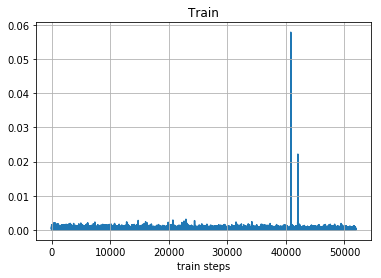

 62%|██████▏   | 4600/7422 [21:23<12:55,  3.64it/s]

In [0]:
#20
train(dataset, test_batches, model, optimizer, 20)

In [0]:
checkpoint = torch.load("drive/diploma/BME/model_9")
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

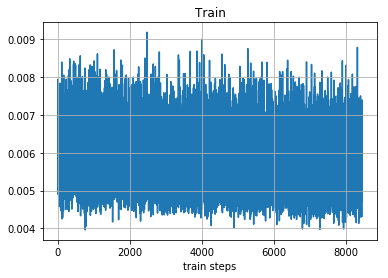

In [0]:
plot_history(checkpoint["plot_losses"][140000:], "Train")

Loss - 0.4188101887702942
Epoch - 3


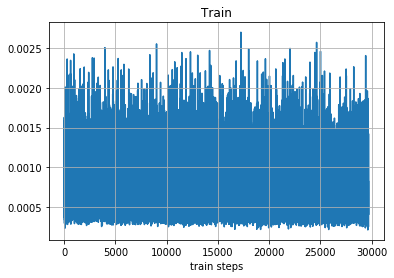

 89%|████████▉ | 6618/7422 [1:03:09<07:39,  1.75it/s]

In [0]:
#10 + 3 + 4 + 6 + 4 + 5
train(dataset, test_batches, model, optimizer, 10, lr=0.001)

100%|██████████| 1860/1860 [04:54<00:00,  6.42it/s]


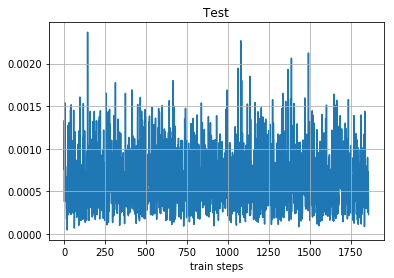

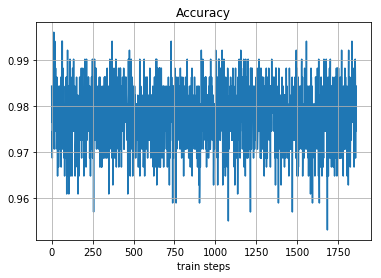

Mean accuracy - 0.9778897849462366


[0.0003875590628013015,
 0.0013325022300705314,
 0.0007510889554396272,
 0.001275123911909759,
 0.001540772500447929,
 0.0010871818521991372,
 0.0011038485681638122,
 0.0006447584019042552,
 0.0007930735591799021,
 0.0006436583935283124,
 0.0003857178089674562,
 0.0005266031948849559,
 0.00048533969675190747,
 0.0003121487097814679,
 0.0002826447016559541,
 0.00017593574011698365,
 0.0004003118956461549,
 0.0006741981487721205,
 0.000606011541094631,
 4.815385182155296e-05,
 0.0005338913179002702,
 0.0006485031917691231,
 0.0012733449693769217,
 0.0007655821391381323,
 0.000408651540055871,
 0.00027067161863669753,
 0.00022672883642371744,
 0.00029673645622096956,
 0.00038259607390500605,
 0.00033823365811258554,
 0.0005822539096698165,
 0.0013091973960399628,
 0.0002565600152593106,
 0.00039410972385667264,
 0.0007345617050305009,
 0.00048413852346129715,
 0.0008940807310864329,
 0.00027278263587504625,
 0.0005459169042296708,
 0.0014644430484622717,
 0.00073588005034253,
 0.000229414

In [0]:
# 17
loss_log = []
acc_log = []
criterion = nn.NLLLoss()
test(model, criterion, test_batches, loss_log, acc_log)




In [0]:
!pip install pymorphy2

    100% |████████████████████████████████| 51kB 6.5MB/s 
    100% |████████████████████████████████| 7.1MB 5.1MB/s 


100%|██████████| 1860/1860 [05:32<00:00,  5.73it/s]


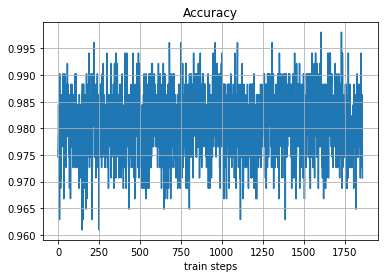

Mean accuracy - 0.9812920026881721


In [0]:

import pymorphy2

acc_log = []
morph = pymorphy2.MorphAnalyzer()
t = 0
for batch_num, batch in zip(trange(len(test_batches)), test_batches):
  X = batch[0]
  X_f = np.array([re.split(",| ", batch[1][i]) for i in range(len(batch[1]))])
  y = batch[2]
  norm_form = np.array([re.split(",| ", batch[3][i]) for i in range(len(batch[1]))])
#   print(np.array(X_f)[:, 0])
#   print(np.array(X_f))
  acc = 0
  neg_acc = 0
  for i in range(len(X)):
    py_lemmas = morph.parse(X[i][1:-1])
    morph_set = set(X_f[i])
    py_lemma = 0
#     print(py_lemmas)
    if "ms-f" in norm_form[i]:
      for j, elem in enumerate(norm_form[i]):
        if elem == "ms-f":
          norm_form[i][j] = "Ms-f"
    for p_lem in py_lemmas:
#       print(p_lem.tag.POS)
      if set(norm_form[i]) in p_lem.tag:
        py_lemma = p_lem
#     print(py_lemma)
#     print(morph_set)
    try: 
      pred = py_lemma.inflect(morph_set).word
    except:
      t += 1
      
#     print(y[i][1:-1])
#     print(pred)
    acc += pred == y[i][1:-1]
#     print(acc)
#     print("pred", pred)
#     print("target", y[i][1:-1])
#     print("Norm", X[i][1:-1])
#     print(morph_set)
#     print("Norm features", set(norm_form[i]))
    neg_acc += pred != y[i][1:-1]
#   print(acc)
#   print(len(X))
#   print(neg_acc)
  acc_log.append(acc / (acc + neg_acc))
#   if batch_num == 1:
#       break
plot_history(acc_log, title="Accuracy")
print("Mean accuracy - {}".format(np.mean(acc_log)))